In [ ]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Modelo video.

In [ ]:
[1,10]

[1, 10]

In [ ]:
TODO = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Freezers/TODO.csv')
TODO = TODO.drop(columns='Unnamed: 0')

In [ ]:
TODO

,semanas,alarmas_por_semana,Tienda
0,1,1.0,A4930
1,1,1.0,A4441
2,1,2.0,A4399
3,1,2.0,A4188
4,2,1.0,A4148
...,...,...,...
235971,200,2.0,A0730
235972,200,12.0,A0444
235973,200,1.0,A2256
235974,200,1.0,A2128


In [ ]:
TODO['semanas'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

## Split.

In [ ]:
split_point = int(200*0.8)
X_train = TODO[TODO["semanas"] < split_point].copy()
X_val = TODO[TODO["semanas"] >= split_point].copy()

## Relación con la semana siguiente.

In [ ]:
X_train["alarmas_prox_sem"] = X_train.groupby("Tienda")["alarmas_por_semana"].shift(-1)

In [ ]:
X_train = X_train.dropna()

## Añadir 4 características.

### Lag.

In [ ]:
X_train["lag_alarmas_1"] = X_train.groupby("Tienda")["alarmas_por_semana"].shift(1)

### Diferencia.

In [ ]:
X_train["diff_alarmas_1"] = X_train.groupby("Tienda")["alarmas_por_semana"].diff(1)

### Rolling averages.

In [ ]:
X_train["mean_alarmas_4"] = X_train.groupby("Tienda")["alarmas_por_semana"].rolling(4).mean().reset_index(level=0, drop=True)

### Seasonality.

### Para validación.

In [ ]:
X_val["alarmas_prox_sem"] = X_val.groupby("Tienda")["alarmas_por_semana"].shift(-1)
X_val = X_val.dropna()
X_val["lag_alarmas_1"] = X_val.groupby("Tienda")["alarmas_por_semana"].shift(1)
X_val["diff_alarmas_1"] = X_val.groupby("Tienda")["alarmas_por_semana"].diff(1)
X_val["mean_alarmas_4"] = X_val.groupby("Tienda")["alarmas_por_semana"].rolling(4).mean().reset_index(level=0, drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Loss function.

In [ ]:
def mape(y_true, y_pred):
  ape = np.abs((y_true-y_pred)/y_true)
  ape[~np.isfinite(ape)] = 1.
  return np.mean(ape)

def wmape(y_true, y_pred):
  return np.sum(np.abs(y_true-y_pred)) / np.sum(np.sum(y_true))

## Baseline.

Predecir diciendo que el número es igual al de la semana anterior es muy bueno.

In [ ]:
y_pred = X_train['alarmas_por_semana']
y_true = X_train['alarmas_prox_sem']
mape(y_true, y_pred), wmape(y_true, y_pred)

(1.0231016305223335, 0.9232900692483268)

## Modelo.

In [ ]:
features = ['alarmas_por_semana', 'lag_alarmas_1', 'diff_alarmas_1', 'mean_alarmas_4']

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()

Xtr = imputer.fit_transform(X_train[features])
ytr = X_train['alarmas_prox_sem']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)

In [ ]:
model.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

In [ ]:
Xval = imputer.fit_transform(X_val[features])
yval = X_val['alarmas_prox_sem']

p = model.predict(Xval)

In [ ]:
mape(yval, p), wmape(yval, p)

(0.8867091772395175, 0.8046638436445199)

# Modelo pySpark.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Freezers/Data_Time.csv')
data.head()

,Site Number,Date Created
0,A0002,"['08/02/2012', '17/02/2012', '18/02/2012', '23..."
1,A0003,"['01/02/2012', '01/02/2012', '02/02/2012', '02..."
2,A0004,"['09/02/2012', '15/02/2012', '15/02/2012', '23..."
3,A0005,"['05/03/2012', '05/03/2012', '05/03/2012', '06..."
4,A0006,"['08/02/2012', '11/02/2012', '13/02/2012', '18..."


In [ ]:
def to_list_function(string):
    '''
    esta función convierte un string de una
    lista a una lista
    '''
    return np.array(string.strip('][').replace(r"'","" ).split(', '))

In [ ]:
dates = to_list_function(data['Date Created'][1])[:-1]
dates = [str(date) for date in dates]
dates_comps = [np.array(date.split('/')).astype(np.int) for date in dates]
#dates_comps
fechas = [datetime.date(comps[2], comps[1], comps[0]) for comps in dates_comps]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
fechas = np.array(fechas)

In [ ]:
np.unique(fechas, return_counts=True)[0]

In [ ]:
df = pd.DataFrame(columns=['dates', 'A0002'])
df['A0002'] = np.unique(fechas, return_counts=True)[1]
df['dates'] = np.unique(fechas, return_counts=True)[0]
df = df.set_index('dates')
df

,A0002
dates,
2012-02-01,2
2012-02-02,2
2012-02-17,2
2012-02-21,1
2012-02-24,1
...,...
2015-10-22,3
2015-10-24,1
2015-10-25,1


In [ ]:
import datetime
def Order(n, DF):
  row = DF['Site Number'][n]
  dates = to_list_function(DF['Date Created'][n])[:-1]
  dates = [str(date) for date in dates]
  dates_comps = [np.array(date.split('/')).astype(np.int) for date in dates]
  fechas = [datetime.date(comps[2], comps[1], comps[0]) for comps in dates_comps]
  df = pd.DataFrame(columns=['dates', row])
  df[row] = np.unique(fechas, return_counts=True)[1]
  df['dates'] = np.unique(fechas, return_counts=True)[0]
  df = df.set_index('dates')

  return df

In [ ]:
dfs = [Order(i, data) for i in range(len(data))]
#Alarmas = pd.concat(dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
Alarmas = pd.concat(dfs, axis=1).sort_index()

In [ ]:
Alarmas = Alarmas.fillna(0)

In [ ]:
Alarmas

,A0002,A0003,A0004,A0005,A0006,A0007,A0008,A0009,A0011,A0014,...,P2289,P2290,P2293,P2295,P2303,P2308,P2313,P2314,P2625,P2835
dates,,,,,,,,,,,,,,,,,,,,,
2012-02-01,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-02-02,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-02-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-28,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-29,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-10-30,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install prophet pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 54.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=506de62b9d8f6a7153cd1c5102584d23e69de1ea820016858608c352ff085b6b
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [ ]:
from prophet import Prophet
import seaborn as sns
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [ ]:
Alarmas = Alarmas.reset_index()
datafr = pd.melt(Alarmas, id_vars='dates', value_vars=list(Alarmas.columns))
datafr.columns = ['ds', 'site', 'y']
datafr.head()

,ds,site,y
0,2012-02-01,A0002,0.0
1,2012-02-02,A0002,0.0
2,2012-02-03,A0002,0.0
3,2012-02-04,A0002,0.0
4,2012-02-05,A0002,0.0


In [ ]:
grupos_x_sitio = datafr.groupby('site')
grupos_x_sitio.groups.keys()

In [ ]:
def train_forecast(grupo):
  model = Prophet()
  model.fit(grupo)

  future = model.make_future_dataframe(52, freq='W')
  forecast = model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['site'] = grupo['site'].iloc[0]

  return forecast[['ds', 'site', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
sdf = spark.createDataFrame(datafr)

result_schema = StructType([
    StructField('ds', DateType()),
    StructField('site', StringType()),
    StructField('yhat', FloatType()),
    StructField('yhat_lower', FloatType()),
    StructField('yhat_upper', FloatType())
])

spark_forecast = sdf.groupBy('site').applyInPandas(train_forecast, schema = result_schema)

In [ ]:
spark_forecast.show(5)

+----------+-----+------------+-----------+----------+
|        ds| site|        yhat| yhat_lower|yhat_upper|
+----------+-----+------------+-----------+----------+
|2012-02-01|A0004|-0.066346586| -0.9030575|0.77497673|
|2012-02-02|A0004|-0.009543773| -0.8218738| 0.8094153|
|2012-02-03|A0004| 0.058821365| -0.8120461|0.87096465|
|2012-02-04|A0004|  0.08722561| -0.7544505|0.95485353|
|2012-02-05|A0004| 0.064929746|-0.72517574| 0.9332491|
+----------+-----+------------+-----------+----------+
only showing top 5 rows



In [ ]:
pandas_forecast = spark_forecast.toPandas()

In [ ]:
pandas_forecast.to_csv('forcasted.csv')

In [ ]:
prueba = pandas_forecast[pandas_forecast['site']=='A0002']
fechs = list(prueba['ds'])
alarms = list(prueba['yhat'])
alarms_l = list(prueba['yhat_lower'])
alarms_u = list(prueba['yhat_upper'])

In [ ]:
t_dates = Alarmas['dates'][1065:]
t_alarms = Alarmas['A0002'][1065:]

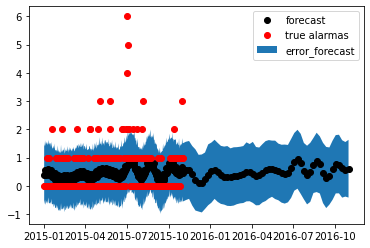

In [ ]:
lim = 1065
plt.plot(fechs[lim:], alarms[lim:], 'ko', label='forecast')
plt.plot(t_dates, t_alarms, 'ro', label='true alarmas')
plt.fill_between(fechs[lim:], alarms_l[lim:], alarms_u[lim:], label='error_forecast')
plt.legend()

# Mensual.

In [ ]:
dates = to_list_function(data['Date Created'][1])[:-1]
fechas = [str(date) for date in dates]
#dates_comps = [np.array(date.split('/')).astype(np.int) for date in dates]
#fechas = [datetime.date(comps[2], comps[1], comps[0]) for comps in dates_comps]

In [ ]:
moths = [date[::-1].rsplit("/", 1)[0][::-1] for date in fechas]
months, freq = np.unique(moths, return_counts=True)

In [ ]:
fechas

In [ ]:
months, freq

(array(['01/2013', '01/2014', '01/2015', '02/2012', '02/2013', '02/2014',
        '02/2015', '03/2013', '03/2014', '03/2015', '04/2012', '04/2013',
        '04/2014', '04/2015', '05/2012', '05/2013', '05/2014', '05/2015',
        '06/2012', '06/2013', '06/2014', '06/2015', '07/2012', '07/2013',
        '07/2014', '07/2015', '08/2012', '08/2013', '08/2014', '08/2015',
        '09/2012', '09/2013', '09/2014', '09/2015', '10/2012', '10/2013',
        '10/2014', '10/2015', '11/2012', '11/2013', '11/2014', '12/2012',
        '12/2013', '12/2014'], dtype='<U7'),
 array([ 27,  28,  24,   8,  26,  13,  51,  21,  12,  40,   4,  13,  11,
         34,  16,  29,  45,  34,  26,  12,  45,  46,  35,  90,  65,  40,
         27,  49,  40,  57,  14,  68,  46,  31,  65, 134,  35,  20,  43,
         58,  41, 100,  18,  22]))

In [ ]:
from datetime import datetime
datetime.strptime(months[0], '%m/%Y').date()

datetime.date(2013, 1, 1)

In [ ]:
fechas = [datetime.strptime(comps, '%m/%Y').date() for comps in months]

In [ ]:
df = pd.DataFrame(columns=['dates', 'A0002'])
df['A0002'] = freq
df['dates'] = fechas
df = df.set_index('dates')
df = df.sort_index()
df

,A0002
dates,
2012-02-01,8
2012-04-01,4
2012-05-01,16
2012-06-01,26
2012-07-01,35
2012-08-01,27
2012-09-01,14
2012-10-01,65
2012-11-01,43


In [ ]:
def M_Order(n, DF):
  row = DF['Site Number'][n]
  dates = to_list_function(DF['Date Created'][n])[:-1]
  dates = [str(date) for date in dates]
  moths = [date[::-1].rsplit("/", 1)[0][::-1] for date in dates]
  months, freq = np.unique(moths, return_counts=True)
  fechas = [datetime.strptime(comps, '%m/%Y').date() for comps in months]
  df = pd.DataFrame(columns=['dates', row])
  df[row] = freq
  df['dates'] = fechas
  df = df.set_index('dates')
  df = df.sort_index()

  return df

In [ ]:
M_Order(1, data)

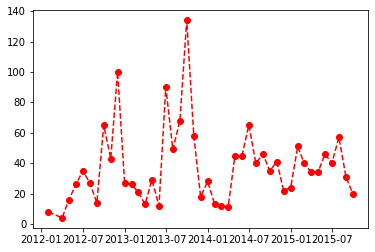

In [ ]:
plt.plot(list(M_Order(1, data).index), M_Order(1, data)['A0003'], 'ro--')

In [ ]:
mdfs = [M_Order(i, data) for i in range(len(data))]

In [ ]:
M_Alarmas = pd.concat(mdfs, axis=1)
M_Alarmas = M_Alarmas.fillna(0)
M_Alarmas = M_Alarmas.sort_index()
M_Alarmas

,A0002,A0003,A0004,A0005,A0006,A0007,A0008,A0009,A0011,A0014,...,P2289,P2290,P2293,P2295,P2303,P2308,P2313,P2314,P2625,P2835
dates,,,,,,,,,,,,,,,,,,,,,
2012-02-01,7.0,8.0,4.0,0.0,8.0,4.0,0.0,37.0,12,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2012-03-01,4.0,0.0,1.0,26.0,2.0,4.0,8.0,19.0,32,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-04-01,4.0,4.0,4.0,6.0,3.0,2.0,6.0,15.0,14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-05-01,7.0,16.0,4.0,8.0,13.0,21.0,17.0,28.0,23,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-06-01,9.0,26.0,1.0,8.0,1.0,15.0,23.0,14.0,6,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-07-01,9.0,35.0,2.0,10.0,6.0,21.0,29.0,146.0,11,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-08-01,35.0,27.0,3.0,5.0,0.0,16.0,27.0,143.0,20,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-09-01,5.0,14.0,1.0,3.0,7.0,12.0,21.0,8.0,6,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2012-10-01,11.0,65.0,8.0,4.0,12.0,23.0,8.0,6.0,13,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
M_Alarmas = M_Alarmas.reset_index()
mdatafr = pd.melt(M_Alarmas, id_vars='dates', value_vars=list(M_Alarmas.columns))
mdatafr.columns = ['ds', 'site', 'y']
mdatafr.head()

,ds,site,y
0,2012-02-01,A0002,7.0
1,2012-03-01,A0002,4.0
2,2012-04-01,A0002,4.0
3,2012-05-01,A0002,7.0
4,2012-06-01,A0002,9.0


In [ ]:
mgrupos_x_sitio = mdatafr.groupby('site')
mgrupos_x_sitio.groups.keys()

In [ ]:
def train_mforecast(grupo):
  model = Prophet()
  model.fit(grupo)

  future = model.make_future_dataframe(12, freq='M')
  forecast = model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['site'] = grupo['site'].iloc[0]

  return forecast[['ds', 'site', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
msdf = spark.createDataFrame(mdatafr)

result_schema = StructType([
    StructField('ds', DateType()),
    StructField('site', StringType()),
    StructField('yhat', FloatType()),
    StructField('yhat_lower', FloatType()),
    StructField('yhat_upper', FloatType())
])

mspark_forecast = msdf.groupBy('site').applyInPandas(train_mforecast, schema = result_schema)

In [ ]:
mspark_forecast.show(5)

+----------+-----+---------+----------+----------+
|        ds| site|     yhat|yhat_lower|yhat_upper|
+----------+-----+---------+----------+----------+
|2012-02-01|A0002|4.2209706| -2.848794| 11.504897|
|2012-03-01|A0002| 7.927124|0.21528222| 15.219038|
|2012-04-01|A0002| 7.303866| 0.5619615| 14.964837|
|2012-05-01|A0002| 9.837269| 2.4924624| 17.067802|
|2012-06-01|A0002|7.7012544|0.78272593|14.9254465|
+----------+-----+---------+----------+----------+
only showing top 5 rows



In [ ]:
mpandas_forecast = mspark_forecast.toPandas()

In [ ]:
mpandas_forecast.to_csv('month_forecast.csv')

In [ ]:
load = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Freezers/month_forecast.csv')

In [ ]:
mprueba = load[load['site']=='A0002']
mfechs = list(mprueba['ds'])
malarms = list(mprueba['yhat'])
malarms_l = list(mprueba['yhat_lower'])
malarms_u = list(mprueba['yhat_upper'])

In [ ]:
mnfechs = [datetime.strptime(comps, '%Y-%m-%d').date() for comps in mfechs]
mnfechs

In [ ]:
list(M_Alarmas['A0002'])[-12:]

[4.0, 6.0, 8.0, 12.0, 13.0, 17.0, 15.0, 34.0, 14.0, 2.0, 17.0, 1.0]

In [ ]:
list(M_Alarmas.dates)[lim3:]

[datetime.date(2014, 12, 1),
 datetime.date(2015, 1, 1),
 datetime.date(2015, 2, 1),
 datetime.date(2015, 3, 1),
 datetime.date(2015, 4, 1),
 datetime.date(2015, 5, 1),
 datetime.date(2015, 6, 1),
 datetime.date(2015, 7, 1),
 datetime.date(2015, 8, 1),
 datetime.date(2015, 9, 1),
 datetime.date(2015, 10, 1),
 datetime.date(2015, 11, 1)]

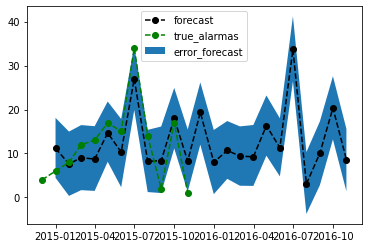

In [ ]:
lim = 35
lim2 = 34
lim3 = -12
plt.plot(mnfechs[lim:], malarms[lim:], 'ko--', label='forecast')
#plt.plot(list(M_Order(0, data).index)[lim2:], list(M_Order(0, data)['A0002'][lim2:]), 'ro--', label='true_alarmas')
plt.plot(list(M_Alarmas.dates)[lim3:], M_Alarmas['A0002'][lim3:], 'go--', label='true_alarmas')
plt.fill_between(mnfechs[lim:], malarms_l[lim:], malarms_u[lim:], label='error_forecast')
plt.legend()

In [ ]:
from sklearn.metrics import r2_score

y_true = list(M_Order(0, data)['A0002'][lim2:])
y_pred = malarms[lim:lim+len(y_true)]
MSE = np.square(np.subtract(y_true,y_pred)).mean()
r2 = r2_score(y_true, y_pred)
wm_scr = wmape(np.array(y_true), np.array(y_pred))
print("MSE: {}".format(MSE))
print("R^2: {}".format(r2))
print("WMAPE: {}".format(wm_scr))

MSE: 23.44453920210866
R^2: 0.6841695342401305
WMAPE: 0.33962153453237415


### Evaluación.

In [ ]:
n = 2
n_samples=np.random.randint(0, load['site'].unique().shape[0], n*n)
ran_indx_matrix=n_samples.reshape(n, n)
ran_indx_matrix

array([[  29, 1359],
       [ 928,  898]])

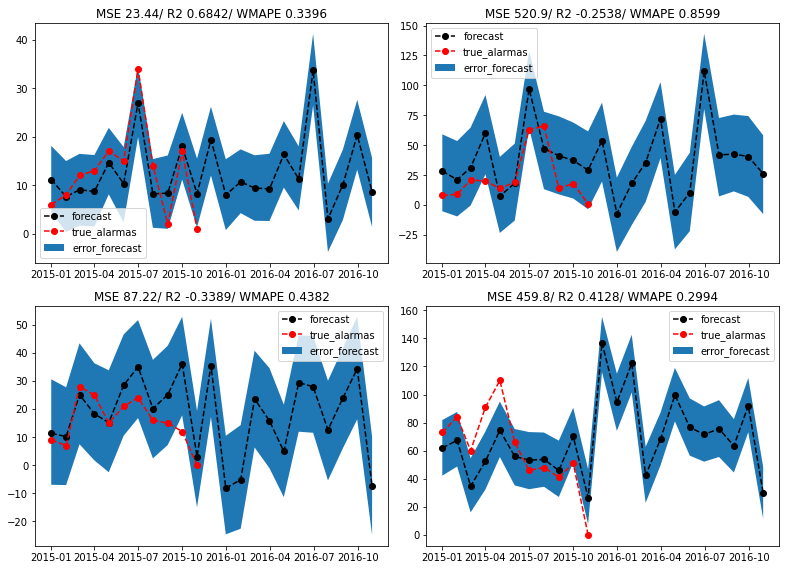

In [ ]:
fig,ax=plt.subplots(n, n, figsize=(11,8))
for i in range(0,ran_indx_matrix.shape[0]):
    for j in range(0,ran_indx_matrix.shape[1]):
        #the ij entry of this matrix is the random index of the image.
        k = ran_indx_matrix[i,j]

        mprueba = load[load['site']==load['site'].iloc[k]]
        mfechs = list(mprueba['ds'])
        malarms = list(mprueba['yhat'])
        malarms_l = list(mprueba['yhat_lower'])
        malarms_u = list(mprueba['yhat_upper'])
        mnfechs = [datetime.strptime(comps, '%Y-%m-%d').date() for comps in mfechs]

        y_true = M_Alarmas[load['site'].iloc[k]][lim3:]
        y_pred = malarms[lim:lim+len(y_true)]
        MSE = np.square(np.subtract(y_true,y_pred)).mean()
        r2 = r2_score(y_true, y_pred)
        wm_scr = wmape(np.array(y_true), np.array(y_pred))
        
        lim = 35
        lim2 = 34
        lim3 = -11
        ax[i,j].plot(mnfechs[lim:], malarms[lim:], 'ko--', label='forecast')
        ax[i,j].plot(list(M_Alarmas.dates)[lim3:], M_Alarmas[load['site'].iloc[k]][lim3:], 'ro--', label='true_alarmas')
        ax[i,j].fill_between(mnfechs[lim:], malarms_l[lim:], malarms_u[lim:], label='error_forecast')
        ax[i,j].legend()
        
        #ploting the image.
        #title = 'MSE '+str(MSE)+' / R2 '+str(r2)+' / WMAPE '+str(wm_scr)
        title = 'RMSE {:.4}/ R2 {:.4}/ WMAPE {:.4}'.format(np.sqrt(MSE), r2, wm_scr)
        ax[i,j].set_title(title)
        #ax[i,j].set_axis_off()
        
#setting the separation between subplots.        
fig.tight_layout(pad=1.0)
plt.savefig('forecast.png')

# Adding Lags.

In [ ]:
lagAlams = M_Alarmas.copy()

In [ ]:
lagAlams.tail(11)

,A0002,A0003,A0004,A0005,A0006,A0007,A0008,A0009,A0011,A0014,...,P2289,P2290,P2293,P2295,P2303,P2308,P2313,P2314,P2625,P2835
dates,,,,,,,,,,,,,,,,,,,,,
2015-01-01,6.0,24.0,8.0,4.0,10.0,12.0,14.0,1.0,16,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-02-01,8.0,51.0,3.0,12.0,16.0,10.0,10.0,10.0,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-03-01,12.0,40.0,1.0,18.0,15.0,15.0,13.0,5.0,32,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-01,13.0,34.0,4.0,30.0,27.0,21.0,8.0,9.0,14,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2015-05-01,17.0,34.0,9.0,24.0,29.0,7.0,9.0,4.0,12,3.0,...,4.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0
2015-06-01,15.0,46.0,10.0,19.0,37.0,25.0,19.0,4.0,12,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0
2015-07-01,34.0,40.0,5.0,11.0,75.0,19.0,14.0,53.0,54,16.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2015-08-01,14.0,57.0,13.0,14.0,44.0,5.0,25.0,12.0,26,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-09-01,2.0,31.0,0.0,6.0,47.0,15.0,6.0,6.0,39,5.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
split_point = 11 #Year 2015
X_train = lagAlams.copy().head(len(lagAlams)-split_point)
X_val = lagAlams.copy().tail(split_point)

In [ ]:
X_train = X_train.reset_index()
X_series = pd.melt(X_train, id_vars='dates', value_vars=list(X_train.columns))
X_series.columns = ['ds', 'site', 'y']
X_series.head()

,ds,site,y
0,2012-02-01,A0002,7.0
1,2012-03-01,A0002,4.0
2,2012-04-01,A0002,4.0
3,2012-05-01,A0002,7.0
4,2012-06-01,A0002,9.0


In [ ]:
X_series["lag_alarmas_1"] = X_series.groupby("site")["y"].shift(1)
X_series["lag_alarmas_2"] = X_series.groupby("site")["y"].shift(2)
X_series["lag_alarmas_3"] = X_series.groupby("site")["y"].shift(3)

In [ ]:
X_series.tail()

,ds,site,y,lag_alarmas_1,lag_alarmas_2,lag_alarmas_3
55155,2014-08-01,P2835,5.0,9.0,3.0,0.0
55156,2014-09-01,P2835,1.0,5.0,9.0,3.0
55157,2014-10-01,P2835,3.0,1.0,5.0,9.0
55158,2014-11-01,P2835,1.0,3.0,1.0,5.0
55159,2014-12-01,P2835,0.0,1.0,3.0,1.0


In [ ]:
X_series = X_series.dropna()

In [ ]:
X_series.head()

,ds,site,y,lag_alarmas_1,lag_alarmas_2,lag_alarmas_3
3,2012-05-01,A0002,7.0,4.0,4.0,7.0
4,2012-06-01,A0002,9.0,7.0,4.0,4.0
5,2012-07-01,A0002,9.0,9.0,7.0,4.0
6,2012-08-01,A0002,35.0,9.0,9.0,7.0
7,2012-09-01,A0002,5.0,35.0,9.0,9.0


In [ ]:
X_series.corrwith(X_series["y"])

y                1.000000
lag_alarmas_1    0.626553
lag_alarmas_2    0.507314
lag_alarmas_3    0.432423
dtype: float64

In [ ]:
def train_mforecast(grupo):
  model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
  model.add_regressor(['lag_alarmas_1', 'lag_alarmas_2', 'lag_alarmas_3'], standardize=False)
  model.fit(grupo)

  future = model.make_future_dataframe(24, freq='M')

  future = pd.merge(future, grupo[['ds', 'lag_alarmas_1']], on='ds', how='inner')
  future = pd.merge(future, grupo[['ds', 'lag_alarmas_2']], on='ds', how='inner')
  future = pd.merge(future, grupo[['ds', 'lag_alarmas_3']], on='ds', how='inner')

  future = future.fillna(method='ffill')

  forecast = model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['site'] = grupo['site'].iloc[0]

  return forecast[['ds', 'site', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
msdf = spark.createDataFrame(X_series)

result_schema = StructType([
    StructField('ds', DateType()),
    StructField('site', StringType()),
    StructField('yhat', FloatType()),
    StructField('yhat_lower', FloatType()),
    StructField('yhat_upper', FloatType())
])

mspark_forecast = msdf.groupBy('site').applyInPandas(train_mforecast, schema = result_schema)

In [ ]:
mspark_forecast.show(5)

PythonException: ignored

In [ ]:
mpandas_forecast = mspark_forecast.toPandas()

PythonException: ignored